Skład grupy:

Natalia Przewdzięk, 276052

Mateusz Skrzątek, 275975

Agata Stachnio, 268330

# Zadanie 2
## Generowanie rozkładu normalnego poznanymi sposobami

Wszystkie przedstawione algorytmy generowania zmiennych z rozkładu normalnego zwracją jedną lub dwie zmienne o rozkładzie $N(\mu, \sigma^2)$. Na zajęciach poznaliśmy metody:
<ul>
    <li>metoda odwrotnej dystrybuanty</li>
    <li>metoda akceptacji-odrzucenia (rejection method),</li>
    <li>metoda biegunowa Box'a-Muller'a,</li>
    <li>metoda biegunowa Marsaglii,</li>
</ul>

które zostały opisane oraz zaimplementowane poniżej. Dodatkowo zaimplementowano metody tuzina oraz zigguratu.

W każdej z tym metod wygenerowano najpierw zmienną $Y \sim N(0,1)$ a następnie korzystając z własności rozkładu normalnego uzyskano $X = \sigma Y + \mu \sim N(\mu, \sigma^2)$.

Użyte biblioteki to:

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.special import erfinv
from scipy.stats import expon, norm

### Metoda odwrotnej dystrybuanty

Metoda ta opiera się na generowaniu wartości przy użyciu funkcji odwrotnej $F^{-1}(U)$ do funkcji dystrybuanty, gdzie $U \sim U(0,1)$. Rozkład normalny posiada dystrybuantę postaci $\frac{1}{2}(1+erf(\frac{x - \mu}{\sigma \sqrt{2}}))$, jej odwrotność to
$$
F^{-1}(y) = \sigma \sqrt{2} erf^{-1}(2y - 1) + \mu
$$
Implementacja funkcji $erf^{-1}$ jest dostępna w bibliotece scipy.special pod nawą erfinv().

In [2]:
def odwrotna(mu: int = 0, sigma: int = 1, size: int = 1) -> np.ndarray:
    """
    Generator zmiennych losowych z rozkładu normalnego metodą odwrotnej dystrybuanty.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        np.ndarray: tablica z wartościami wygenerowanych
            zmiennych losowych z rozkładu normalnego.

    Examples:
        >>> odwrotna(0, 1, 1)
        array([0.98274533])
        >>> odwrotna(3, 2, 2)
        array([2.69279284, 6.32020055])
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")
    U = np.random.uniform(0, 1, size)
    X = np.sqrt(2) * sigma * erfinv(2 * U - 1) + mu
    return X

Poniżej przedstawiono porównanie teoretycznych oraz empirycznych gęstości i dystrybuant dla wygenerowanej metodą odwrotnej dystrybuanty próby losowej z rozkładu $N(0,1)$. Obie funkcje pokrywają się z ich teoretycznymi odpowiednikami. 

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

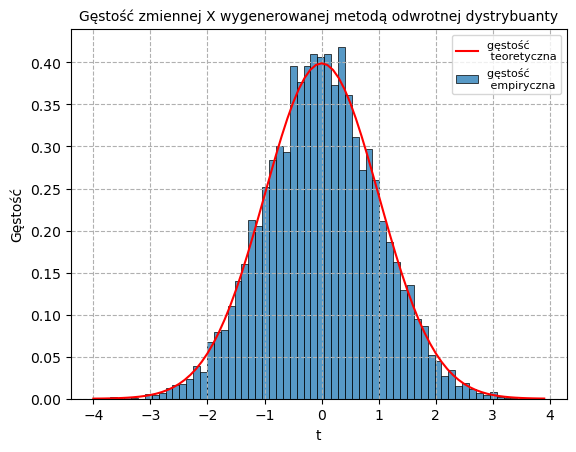

<Figure size 400x300 with 0 Axes>

In [3]:
x_o = odwrotna(0, 1, 10**4)
t = np.arange(-4, 4, 0.1)

plt.plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość \n teoretyczna")
sns.histplot(x_o, stat="density", label="gęstość \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Gęstość")
plt.legend(loc="upper right", prop={"size": 8})
plt.title("Gęstość zmiennej X wygenerowanej metodą odwrotnej dystrybuanty", fontsize=10)
plt.figure(figsize=(4, 3))

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

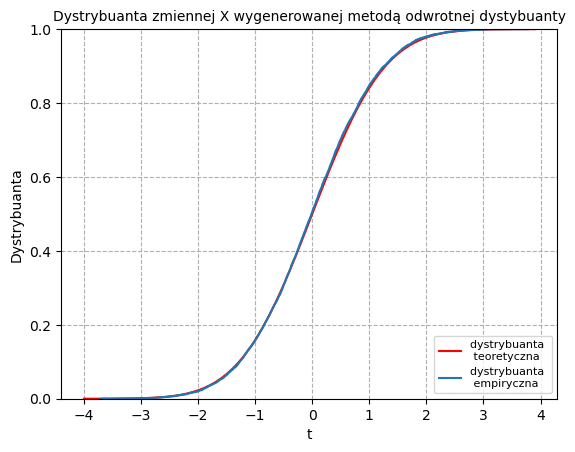

<Figure size 400x300 with 0 Axes>

In [4]:
plt.plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta \n teoretyczna")
sns.ecdfplot(x_o, label="dystrybuanta \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Dystrybuanta")
plt.legend(loc="lower right", prop={"size": 8})
plt.title(
    "Dystrybuanta zmiennej X wygenerowanej metodą odwrotnej dystybuanty", fontsize=10
)
plt.figure(figsize=(4, 3))

### Metoda akceptacji-odrzucenia (rejection method)

Metoda akceptacji-odrzucenia generowania ciągłych zmiennych losowych $X$ o gęstości $f(x)$ zakłada, że możliwe jest efektywne wygenerowanie innej zmiennej losowej $Y$  o znanej gęstości $g(x)$ przyjmującej wartości z tego samego zbioru co $X$ oraz możliwe jest wyznaczenie stałej $c\in(0,\infty)$, która spełnia $\max_{x\in R}\frac{f(x)}{g(x)} \leq c$. 

Najbardziej optymalną wartością $c$ jest $c=\max_{x\in R}\frac{f(x)}{g(x)}$. Ogólny algorytm implementacji tej metody wygląda nastepująco
1. Generuj $Y \sim Exp(1)$.
2. Generuj $U \sim U(0,1)$.
3. Jeśli $U \leq \frac{f(x)}{cg(x)}$ zwróć $X=Y$, w przeciwnym razie wróć do 1.

W przypadku generowania rozkładu normalnego weźmiemy odpowiednio funkcje gęstości $f(x) = \frac{2}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}$ oraz $g(x)=e^{-x}$ zzdefiniowane na przedziale $x \in (0, \infty)$.

Ustalmy $c=\max_{x\in R}\frac{f(x)}{g(x)} = \max_{x\in R}\frac{2}{\sqrt{2\pi}} e^{x-\frac{x^2}{2}} = \sqrt{\frac{2e}{\pi}}$. Wtedy w punkcie 3. algorytmu sprawdzana jest nierówność $U \leq \frac{f(x)}{cg(x)}$, gdzie $\frac{f(x)}{cg(x)} = e^{x-\frac{x^2}{2} - \frac{1}{2}} =e^{-\frac{(x-1)^2}{2}}$.
Zatem
$$
U \leq e^{-\frac{(x-1)^2}{2}} \\
-\log U \leq -\frac{(x-1)^2}{2}
$$
Jednak $-\log U$ to zmienna z rozkładu wykładniczego $\sim Exp(1)$ więc końcowy algorytm będzie miał postać
1. Generuj $Y_1, Y_2 \sim Exp(1)$, $Y_1, Y_2$ iid.
3. Jeśli $Y_2 - \frac{(Y_1 - 1)^2}{2} > 0$ zwróć $X=Y_1$, w przeciwnym razie wróć do 1.

Tym sposobem generujemy rozkład tylko dla wartości dodatnich, w ostatnich kroku przy pomocy wygenerowanej zmiennej jednostajnej dla połowy wyników należy zmienić znak $X$.

In [5]:
def rejection_method(mu: int = 0, sigma: int = 1, size: int = 1) -> np.ndarray:
    """
    Generator zmiennych losowych z rozkładu normalnego metodą akceptacji-odrzucenia.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego z przedziału
            (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        np.ndarray: tablica z wartościami wygenerowanych
            zmiennych losowych z rozkładu normalnego.

    Examples:
        >>> rejection_method(0, 1, 1)
        array([0.40761332])
        >>> rejection_method(3, 2, 2)
        array([-2.67902174,  3.99113335,  1.39388796,  8.26895257])
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")
    y = np.zeros(size)
    i = 0
    while i < size:
        y_1 = expon.rvs(scale=1)
        y_2 = expon.rvs(scale=1)
        if (y_2 - 0.5 * (y_1 - 1) ** 2) > 0:
            u = np.random.uniform()
            if u <= 0.5:
                y[i] = y_1
            else:
                y[i] = -y_1
            i += 1
    return sigma * y + mu

Poniżej przedstawiono porównanie teoretycznych oraz empirycznych gęstości i dystrybuant dla wygenerowanej metodą akceptacji-odrzucenia próby losowej z rozkładu $N(0,1)$. Obie funkcje pokrywają się z ich teoretycznymi odpowiednikami.

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

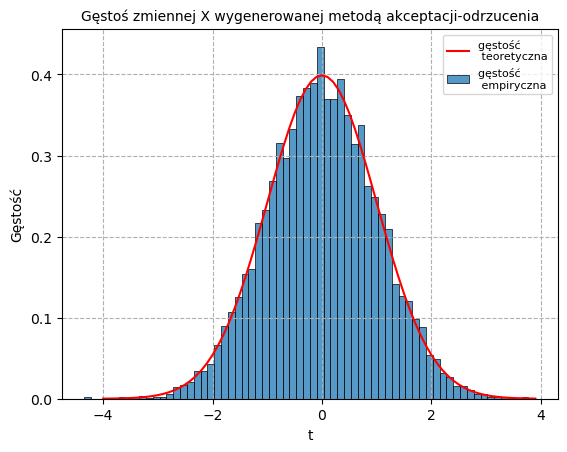

<Figure size 400x300 with 0 Axes>

In [6]:
x_r = rejection_method(0, 1, 10**4)
t = np.arange(-4, 4, 0.1)

plt.plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość \n teoretyczna")
sns.histplot(x_r, stat="density", label="gęstość \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Gęstość")
plt.legend(loc="upper right", prop={"size": 8})
plt.title("Gęstoś zmiennej X wygenerowanej metodą akceptacji-odrzucenia", fontsize=10)
plt.figure(figsize=(4, 3))

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

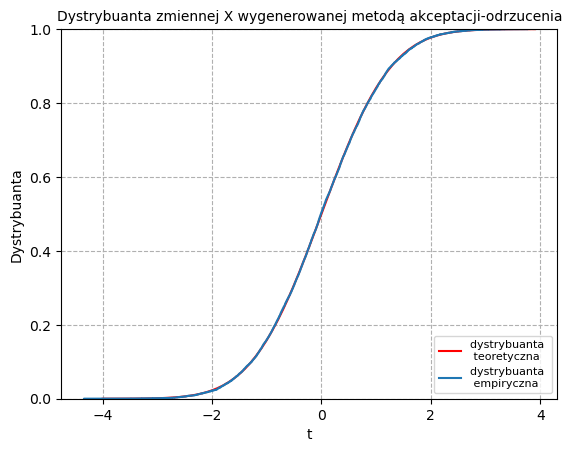

<Figure size 400x300 with 0 Axes>

In [7]:
plt.plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta \n teoretyczna")
sns.ecdfplot(x_r, label="dystrybuanta \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Dystrybuanta")
plt.legend(loc="lower right", prop={"size": 8})
plt.title(
    "Dystrybuanta zmiennej X wygenerowanej metodą akceptacji-odrzucenia", fontsize=10
)
plt.figure(figsize=(4, 3))

### Metoda biegunowa Box'a-Muller'a

Metoda biegunowa Box'a-Muller'a polega na zapisaniu pary zmiennych z rozkładu normalnego jako punkt we współrzęndych biegunowych, gdzie
$$
R^2 = X^2 + Y^2, \quad R^2 \sim Exp(2)
$$
$$
\theta \in [0,2\pi], \quad \theta \sim U(0,2\pi)
$$

W ten sposób otrzymujemy 
$$
X = R\cos\theta = \sqrt{-2 \log U_1} \cos(2\pi U_2)\\
Y = R\sin\theta = \sqrt{-2 \log U_1} \sin(2\pi U_2)
$$
gdzie $U_1,U_2 \sim U(0,1)$ oraz $U_1$ i $U_2$ są niezależne.

In [8]:
def box_muller(mu: int = 0, sigma: int = 1, size: int = 1) -> tuple:
    """
    Generator zmiennych losowych z rozkładu normalnego metodą Box'a-Muller'a.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        tuple: krotka z dwoma tablicami zawierającymi zmienne
            z rozkładu normalnego o średniej mu i odchyleniu standardowym sigma.

    Examples:
        >>> box_muller(0, 1, 1)
        (array([0.34948511]), array([-1.56004532]))
        >>> box_muller(1, 3, 2)
        (array([ 3.86737312, -3.9161212 ]), array([-1.68354414,  6.03852383]))
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")
    u = np.log(np.random.uniform(size=size))
    v = np.random.uniform(size=size)
    x = np.sqrt(-2 * u) * np.cos(2 * np.pi * v)
    y = np.sqrt(-2 * u) * np.sin(2 * np.pi * v)
    return sigma * x + mu, sigma * y + mu

Poniżej przedstawiono porównanie teoretycznych oraz empirycznych gęstości i dystrybuanty dla wygenerowanych metodą Box'a-Muller'a dwóch prób losowych z rozkładu $N(0,1)$. Funkcje w dużym stopniu pokrywają się z ich teoretycznymi odpowiednikami.

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.1, 'Gęstości zmiennych X oraz Y wygenerowanych metodą Boxa-Mullera')

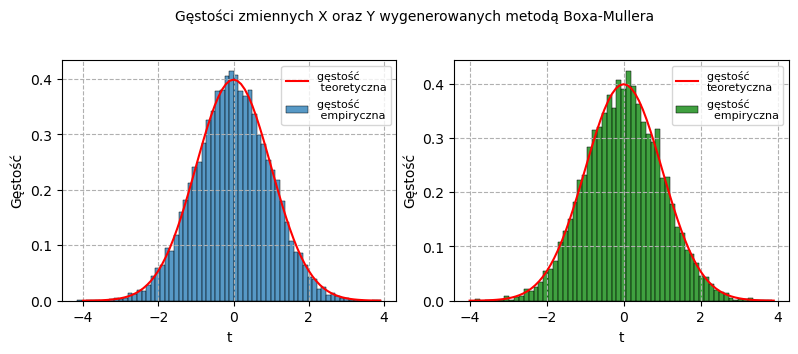

In [9]:
bm_x, bm_y = box_muller(0, 1, 10**4)
t = np.arange(-4, 4, 0.1)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

axes[0].plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość \n teoretyczna")
sns.histplot(bm_x, stat="density", ax=axes[0], label="gęstość \n empiryczna")
axes[0].grid(ls="--")
axes[0].set_xlabel("t")
axes[0].set_ylabel("Gęstość")
axes[0].legend(loc="upper right", prop={"size": 8})

axes[1].plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość  \nteoretyczna")
sns.histplot(
    bm_y, stat="density", ax=axes[1], color="g", label="gęstość \n  empiryczna"
)
axes[1].grid(ls="--")
axes[1].set_xlabel("t")
axes[1].set_ylabel("Gęstość")
axes[1].legend(loc="upper right", prop={"size": 8})
fig.suptitle(
    "Gęstości zmiennych X oraz Y wygenerowanych metodą Boxa-Mullera", fontsize=10, y=1.1
)

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Dystrybuanty zmiennych X oraz Y wygenerowanych metodą Boxa-Mullera')

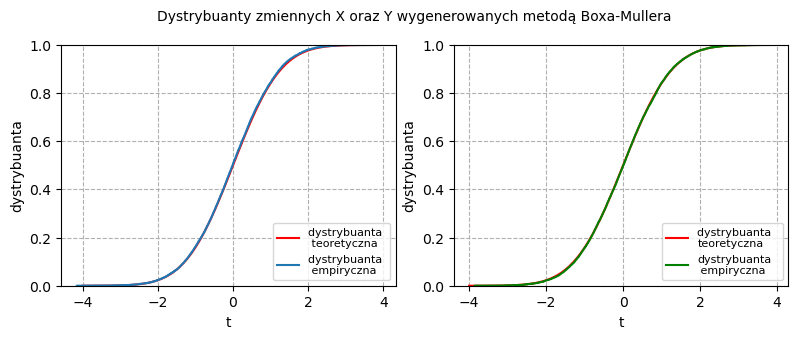

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

axes[0].plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta \n teoretyczna")
sns.ecdfplot(bm_x, ax=axes[0], label="dystrybuanta \n empiryczna")
axes[0].grid(ls="--")
axes[0].set_xlabel("t")
axes[0].set_ylabel("dystrybuanta")
axes[0].legend(loc="lower right", prop={"size": 8})

axes[1].plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta  \nteoretyczna")
sns.ecdfplot(bm_y, ax=axes[1], color="g", label="dystrybuanta\n empiryczna")
axes[1].grid(ls="--")
axes[1].set_xlabel("t")
axes[1].set_ylabel("dystrybuanta")
axes[1].legend(loc="lower right", prop={"size": 8})
fig.suptitle(
    "Dystrybuanty zmiennych X oraz Y wygenerowanych metodą Boxa-Mullera",
    fontsize=10,
    y=1.05,
)

### Metoda biegunowa Marsaglii

Ta metoda bazuje na metodzie Box'a-Muller'a, ale aby uniknąć wyliczania funkcji trygonometrycznych zapisuje je jako
$$
\cos \theta = \frac{V_1}{R} = \frac{V_1}{\sqrt{V_1^2 + V_2^2}} \\
\sin \theta = \frac{V_2}{R} = \frac{V_2}{\sqrt{V_1^2 + V_2^2}}
$$
gdzie $V_1, V_2 \sim U(-1,1)$ oraz $V_1$ i $V_2$ są niezależne. Przy takim zapisie $R^2 = V_1^2 + V_2^2$ ma rozkład U(0,1) zatem możemy je wstawić we wzorach na $X, Y$
$$
X = \sqrt{-2 \log R} \frac{V_1}{R} = V_1 \sqrt{\frac{-2\log R}{R}} \\ 
\\
Y = \sqrt{-2 \log R} \frac{V_1}{R} = V_2 \sqrt{\frac{-2\log R}{R}} 
$$

In [11]:
def marsaglia(mu: int = 0, sigma: int = 1, size: int = 1) -> tuple:
    """
    Generator zmiennych losowych z rozkładu normalnego metodą Marsaglii.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        tuple: krotka z dwoma tablicami zawierającymi zmienne
            z rozkładu normalnego o średniej mu i odchyleniu standardowym sigma.

    Examples:
        >>> marsaglia(0, 1, 1)
        (array([-0.79656311]), array([1.55567173]))
        >>> marsaglia(1, 4, 2)
        (array([10.27782497,  6.98650459]), array([-0.52294246,  4.64245947]))
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")
    i = 0
    x = np.zeros(size)
    y = np.zeros(size)
    while i < size:
        u = np.random.uniform(-1, 1)
        v = np.random.uniform(-1, 1)
        r = u**2 + v**2
        if r <= 1:
            x[i] = np.sqrt((-2 * np.log(r)) / r) * u
            y[i] = np.sqrt((-2 * np.log(r)) / r) * v
            i += 1
    return sigma * x + mu, sigma * y + mu

Poniżej przedstawiono porównanie teoretycznych oraz empirycznych gęstości i dystrybuant dla wygenerowanych metodą Marsagli dwóch prób losowych z rozkładu $N(0,1)$. Funkcje w dużym stopniu pokrywają się z ich teoretycznymi odpowiednikami, jednak można zauważyć różnicę w dopasowaniu funkcji gęstości w porównaniu z metodą Box'a-Muller'a.

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Gęstości zmiennych X oraz Y wygenerowanych metodą Marsaglii')

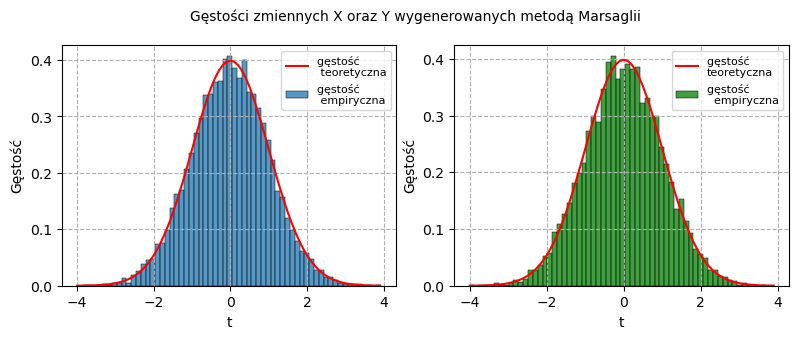

In [12]:
m_x, m_y = marsaglia(0, 1, 10**4)
t = np.arange(-4, 4, 0.1)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

axes[0].plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość \n teoretyczna")
sns.histplot(m_x, stat="density", ax=axes[0], label="gęstość \n empiryczna")
axes[0].grid(ls="--")
axes[0].set_xlabel("t")
axes[0].set_ylabel("Gęstość")
axes[0].legend(loc="upper right", prop={"size": 8})

axes[1].plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość  \nteoretyczna")
sns.histplot(m_y, stat="density", ax=axes[1], color="g", label="gęstość \n  empiryczna")
axes[1].grid(ls="--")
axes[1].set_xlabel("t")
axes[1].set_ylabel("Gęstość")
axes[1].legend(loc="upper right", prop={"size": 8})
fig.suptitle(
    "Gęstości zmiennych X oraz Y wygenerowanych metodą Marsaglii", fontsize=10, y=1.05
)

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Dystrybuanty zmiennych X oraz Y wygenerowanych metodą Marsagli')

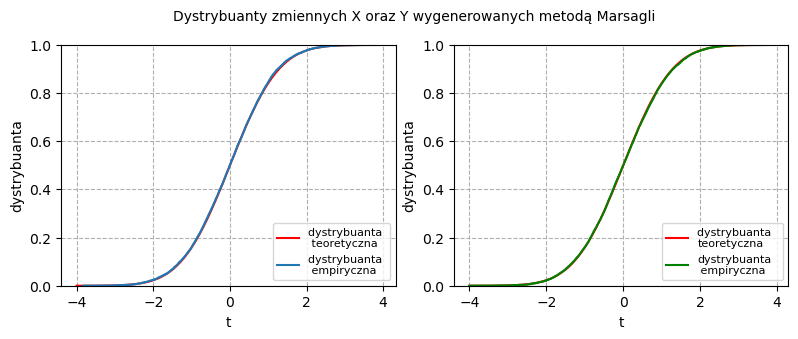

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

axes[0].plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta \n teoretyczna")
sns.ecdfplot(m_x, ax=axes[0], label="dystrybuanta \n empiryczna")
axes[0].grid(ls="--")
axes[0].set_xlabel("t")
axes[0].set_ylabel("dystrybuanta")
axes[0].legend(loc="lower right", prop={"size": 8})

axes[1].plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta  \nteoretyczna")
sns.ecdfplot(m_y, ax=axes[1], color="g", label="dystrybuanta\n empiryczna")
axes[1].grid(ls="--")
axes[1].set_xlabel("t")
axes[1].set_ylabel("dystrybuanta")
axes[1].legend(loc="lower right", prop={"size": 8})
fig.suptitle(
    "Dystrybuanty zmiennych X oraz Y wygenerowanych metodą Marsagli",
    fontsize=10,
    y=1.05,
)

## Metoda Tuzina

Metoda tuzina polega na generowaniu sumy 12 (tuzina) zmiennych losowych z rozkładu jednostajnego a następne zmniejszenietej sumy o 6. Taka zmienna ma $\mu = 0$.

In [14]:
def tuzin(mu: int = 0, sigma: int = 1, size: int = 1) -> np.ndarray:
    """
    Generator zmiennych losowych z rozkładu normalnego metodą Tuzina.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        np.ndarray: tablica z wartościami wygenerowanych zmiennych
            losowych z rozkładu normalnego.

    Examples:
        >>> tuzin(0, 1, 1)
        array([-1.13083729])
        >>> tuzin(1, 4, 2)
        array([ 0.27135622, -2.31936913,  0.37688981,  0.84352579])
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")
    X = np.zeros(size)
    i = 0
    while i < size:
        X[i] = sum(np.random.uniform(size=12)) - 6
        i += 1
    return sigma * X + mu

Poniżej przedstawiono porównanie teoretycznych oraz empirycznych gęstości i dystrybuant dla wygenerowanej metodą tuzina próby losowej z rozkładu $N(0,1)$. Obie funkcje pokrywają się z ich teoretycznymi odpowiednikami.

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

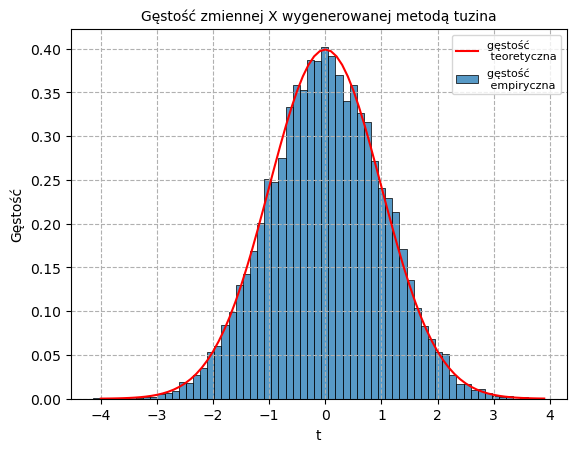

<Figure size 400x300 with 0 Axes>

In [15]:
x_t = tuzin(0, 1, 10**4)
t = np.arange(-4, 4, 0.1)

plt.plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość \n teoretyczna")
sns.histplot(x_t, stat="density", label="gęstość \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Gęstość")
plt.legend(loc="upper right", prop={"size": 8})
plt.title("Gęstość zmiennej X wygenerowanej metodą tuzina", fontsize=10)
plt.figure(figsize=(4, 3))

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

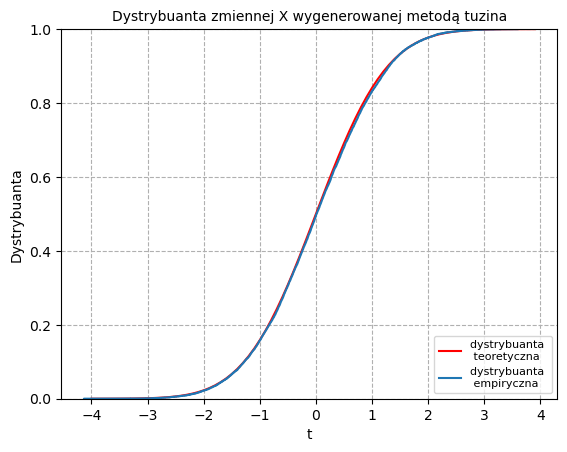

<Figure size 400x300 with 0 Axes>

In [16]:
plt.plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta \n teoretyczna")
sns.ecdfplot(x_t, label="dystrybuanta \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Dystrybuanta")
plt.legend(loc="lower right", prop={"size": 8})
plt.title("Dystrybuanta zmiennej X wygenerowanej metodą tuzina", fontsize=10)
plt.figure(figsize=(4, 3))

## Metoda Zigguratu

Metoda Zigguratu polega na podzieleniu malejącej funkcji gęstości (u nas to $f(x) = e^{-x}$) na "schodki" o równych polach, których dolny róg pokrywa się z wartością funkcji $f(x)$. W implementacji wybrany zostaje n-ty schodek. Losowana jest z niego zmienna o współrzędnych (x,y). Jeśli ten punkt znajduje się na lewo od dolnego rogu schodka powyżej jest on automatycznie przyjmowany. W przeciwnym wypadku sprawdzamy czy punkt znajduje się pod wykresem funkcji, jeśli tak jest to również go przyjmujemy. W przypadku wybrania najniższego schodka, zamiast sprawdzenia czy punkt wpada pod funkcję, stosowany jest tzw. fallback alghoritm:

1. Wstaw $x = \frac{-ln(U_1)}{x_1}$, gdzie $U_1 \sim U(0,1)$.
2. Wstaw $y = -ln(U_2)$, gdzie $U_2 \sim U(0,1)$.
3. Jeśli $2y > x^2$, zwróć $x + x_1$, w przeciwnym wypadku wróć do 1.

In [17]:
def ziggurat(
    mu: int = 0, sigma: int = 1, size: int = 1, layers: int = 100
) -> np.ndarray:
    """
    Generator zmiennych losowych z rozkładu normalnego metodą Zigguratu.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1.
        layers (int, optional): _description_. Domyślnie to 100.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        np.ndarray: tablica z wartościami wygenerowanych zmiennych
            losowych z rozkładu normalnego.

    Examples:
        >>> ziggurat(0, 1, 1)
        array([2.79301862])
        >>> ziggurat(-2, 1, 4)
        array([-1.71514549,  0.2199439 ,  0.85376184,  0.42293613])
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")

    A = (1 - np.exp(-3)) / layers
    x_n = np.zeros(layers + 1)
    y_n = np.zeros(layers + 1)
    x_n[0] = 3
    y_n[0] = A / 3

    for i in range(layers):
        y_n[i + 1] = y_n[i] + A / x_n[i]
        x_n[i + 1] = -np.log(y_n[i + 1])

    Y = np.zeros(size)
    i = 0
    while i < size:
        n = int(layers * np.random.uniform())
        x = x_n[n] * np.random.uniform(-1, 1)
        if abs(x) < x_n[n + 1]:  # punkt poniżej rogu schodka powyżej
            Y[i] = x
            i += 1
        elif n == 0:  # wybrano schodek 0
            j = 0
            while j == 0:
                x = -np.log(np.random.uniform()) / x_n[0]
                y = -2 * np.log(np.random.uniform())
                if y > x**2:
                    if np.random.uniform() <= 0.5:
                        Y[i] = x + x_n[0]
                    else:
                        Y[i] = -x - x_n[0]
                    i += 1
                    j += 1
        else:  # sprawdzmay czy y poniżej funkcji
            y = y_n[n] + np.random.uniform() * (y_n[n + 1] - y_n[n])
            if y < np.exp(-x):
                Y[i] = x
                i += 1
    return sigma * Y + mu

Poniżej przedstawiono porównanie teoretycznych oraz empirycznych gęstości i dystrybuant dla wygenerowanej metodą akceptacji-odrzucenia próby losowej z rozkładu $N(0,1)$. Funkcje nie pokrywają się w pełni z teoretycznymi odpowiednikami. Wygenerownay został rozkład ciężkoogonowy, z większym niż podano odchyleniem standardowym $\sigma$.

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

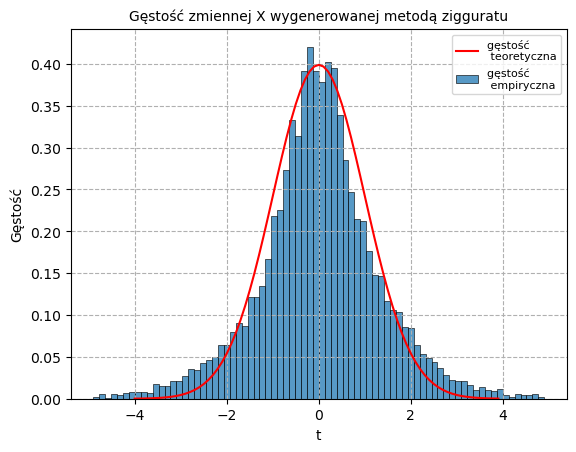

<Figure size 400x300 with 0 Axes>

In [18]:
x_z = ziggurat(0, 1, 10**4)
t = np.arange(-4, 4, 0.1)

plt.plot(t, norm.pdf(t, 0, 1), color="r", label="gęstość \n teoretyczna")
sns.histplot(x_z, stat="density", label="gęstość \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Gęstość")
plt.legend(loc="upper right", prop={"size": 8})
plt.title("Gęstość zmiennej X wygenerowanej metodą zigguratu", fontsize=10)
plt.figure(figsize=(4, 3))

/home/aga/miniconda3/envs/symulacje/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 400x300 with 0 Axes>

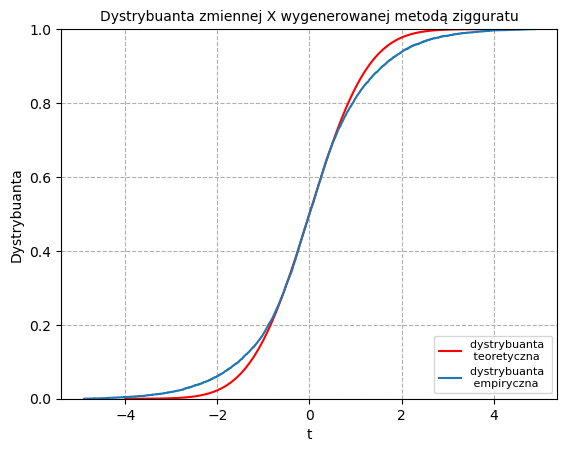

<Figure size 400x300 with 0 Axes>

In [19]:
plt.plot(t, norm.cdf(t, 0, 1), color="r", label="dystrybuanta \n teoretyczna")
sns.ecdfplot(x_z, label="dystrybuanta \n empiryczna")
plt.grid(ls="--")
plt.xlabel("t")
plt.ylabel("Dystrybuanta")
plt.legend(loc="lower right", prop={"size": 8})
plt.title("Dystrybuanta zmiennej X wygenerowanej metodą zigguratu", fontsize=10)
plt.figure(figsize=(4, 3))

## Porównanie czasów działania każdej z metod

Poniższa funkcja liczy czas generowania podanej liczby zmiennych z rozkładu normalnego dla każdej metody zaimpementowanej w tym dokumencie.

In [20]:
def time_it(mu: int = 0, sigma: int = 1, size: int = 100, n_times: int = 100) -> dict:
    """
    Funkcja liczy średni czas generowaia rozkładu normalnego dla generatorów:
        odwrotna dystrybuanta,
        rejection_method,
        box_muller,
        marsaglia,
        tuzin,
        ziggurat.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0,+ inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 100.
        n_times (int, opcjonalne): liczba pomiarów czasu. Domyślnie to 100.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        dict: słownik, gdzie klucz to nazwa funkcji, wartość to średnia
            z n_times pomiarów czasu.

    Examples:
        >>> time_it(0, 1)
        {'odwrotna': 8.343901000008813e-05,
        'rejection_method': 0.012624047619999992,
        'box_muller': 6.30747300000678e-05,
        'marsaglia': 0.0017407256999999988,
        'tuzin': 0.000707475549999943,
        'ziggurat': 0.0008889564399999728}
        >>> time_it(1, 2, 10, 1)
        {'odwrotna': 0.0001136559999999065,
        'rejection_method': 0.0028066459999998017,
        'box_muller': 0.00016709400000003427,
        'marsaglia': 0.000255517999999455,
        'tuzin': 0.00043279299999987586,
        'ziggurat': 0.0007538119999992432}
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")

    func = [odwrotna, rejection_method, box_muller, marsaglia, tuzin, ziggurat]
    times = dict()
    for f in func:
        t = np.zeros(n_times)
        for i in range(n_times):
            t[i] = time.process_time()
            f(mu, sigma, size)
            t[i] = time.process_time() - t[i]
        times[f.__name__] = np.mean(t)
    return times

In [21]:
times = time_it(size=10**4, n_times=100)

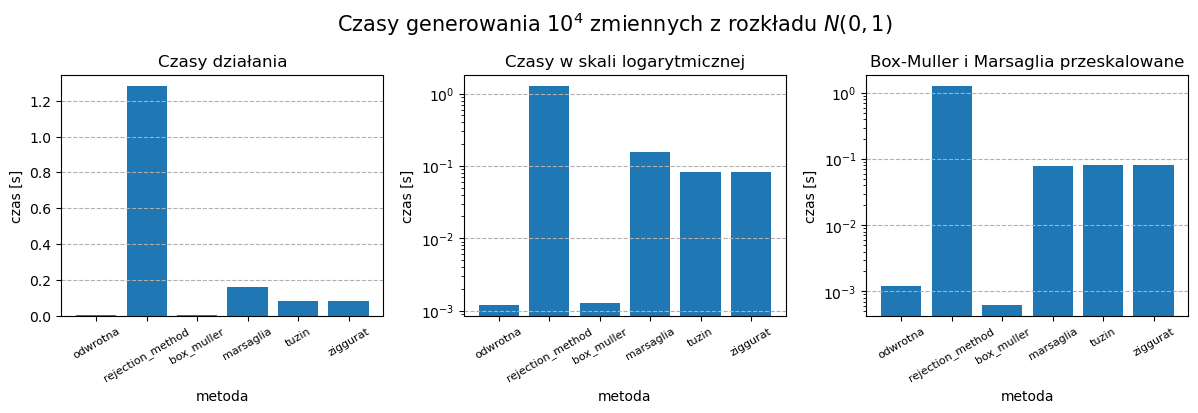

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
fig.tight_layout()

axes[0].bar(range(6), list(times.values()), align="center")
axes[0].set_xticks(range(6), list(times.keys()), fontsize=8, rotation=30)
axes[0].grid(axis="y", linestyle="--")
axes[0].set_xlabel("metoda")
axes[0].set_ylabel("czas [s]")
axes[0].set_title("Czasy działania")

axes[1].bar(range(6), list(times.values()), align="center")
axes[1].set_xticks(range(6), list(times.keys()), fontsize=8, rotation=30)
axes[1].grid(axis="y", linestyle="--")
axes[1].set_xlabel("metoda")
axes[1].set_ylabel("czas [s]")
axes[1].set_yscale("log")
axes[1].set_title("Czasy w skali logarytmicznej")

times_divided = list(times.values())
times_divided[2] *= 0.5
times_divided[3] *= 0.5
axes[2].bar(range(6), times_divided, align="center")
axes[2].set_xticks(range(6), list(times.keys()), fontsize=8, rotation=30)
axes[2].grid(axis="y", linestyle="--")
axes[2].set_xlabel("metoda")
axes[2].set_ylabel("czas [s]")
axes[2].set_title("Box-Muller i Marsaglia przeskalowane")
axes[2].set_yscale("log")

fig.suptitle(
    "Czasy generowania $10^4$ zmiennych z rozkładu $N(0,1)$", fontsize=15, y=1.15
)

fig.subplots_adjust(wspace=0.25)

Dla zaimplemetowanych metod wyznaczono średnie czasy działania dla generowania $10^4$ zmiennych z rozkładu $N(0,1)$ i przedstawiono je na wykresach powyżej. 

Metody biegunowe generują dwie zmienne niezależne dla każdej iteracji na ostatnim wykresie ich wyniki zostały przeskalowane przez $\frac{1}{2}$ aby umożliwić bezpośrednie porównanie z innymi metodami. 

Metoda akceptacji-odrzucenia jest najwolniejsza z wynikiem ponad 2 sekund. Średnia ilość iteracji w algotymie akceptacji-odrzucenia to wartość oblicoznej wcześniej stałej $c= \sqrt{\frac{2e}{\pi}} \approx 1.3154...$ , co oznacza, że funkcja często odrzuca generowany wynik, a dla $10^4$ generowanych zmiennych daje nam to ponad $13$ tysięcy iteracji.

 Metody Marsagli, tuzina oraz zigguratu są porównywalnie szybkie natomiast najlepsze czasy uzykały metody odwrotnej dystybuanty oraz Box'a-Muller'a. Obie z nich korzystają z wbudowanych funkcji erfinv( ), sin oraz cos co znacząco usprawnia ich działanie. Ich działanie byłoby znacznie wolniejsze, gdyby podane funkcje zostały samodzielnie zaimplementowane przez użytkownika. Co ciekawe metoda Marsaglii jest często opisywana jako usprawnienie metody Box'a-Muller'a (m.in. w ,,Simulation" autorstwa Sheldon'a M. Ross'a z 2006 r.) własnie dzięki pominięciu użycia funkcji trygonometrycznych. Możliwym wytłumaczeniem jest to, że implementacja tych funkcji oraz możliwości procesorów znacząco usprawniły szybkość działania funkcji trygnometrycznych w ciągu ostatnich 20 lat.

## Porównanie $\mu$ oraz $\sigma$ wygenerowanych prób losowych

Poniższa funkcja zwraca dwa słowniki z wartościami różnic pomiędzy wyznaczoną wartością $\mu$, a jego wartością podaną przy generowaniu rozkładu oraz wyznaczoną wartością $\sigma$, a jej wartością podaną przy generowaniu rozkładu.

In [23]:
def difference(
    mu: float = 0, sigma: float = 1, size: int = 1000, n_times: int = 100
) -> tuple:
    """
    Funkcja oblicza różnicę pomiędzy podanymi wartościami mu i sigma,
    a obliczonymi z próby losowej dla generatorów:
        odwrotna dystrybuanta,
        rejection_method,
        box_muller,
        marsaglia,
        tuzin,
        ziggurat.

    Args:
        mu (int, opcjonalne): wartość średnia/położenie, liczba rzeczywista.
            Domyślnie 0.
        sigma (int, opcjonalne): wartość odchylenia standardowego
            z przedziału (0, +inf). Domyślnie 1.
        size (int, opcjonalne): wielkość generowanej próby losowej,
            liczba naturalna większa bądź równa 1. Domyślnie to 1000.
        n_times (int, opcjonalne): liczba pomiarów czasu. Domyślnie to 100.

    Raises:
        ValueError: gdy podana wartość sigma nie należy do (0, +inf).

    Returns:
        tuple: krotka zawierająca słowniki z różnicami obliczonych
            i teoretycznych wartości mu i sigma.

    Examples:
        >>> difference(0, 1, 1000, 100)
        ({'odwrotna': 0.025671166104736562,
        'rejection_method': 0.026813467519335842,
        'box_muller': 0.01743942287710811,
        'marsaglia': 0.014003182002430812,
        'tuzin': 0.02363286649291866,
        'ziggurat': 0.031525155550496405},
        {'odwrotna': 0.017232306317830837,
        'rejection_method': 0.018335186526243732,
        'box_muller': 0.014029317240496754,
        'marsaglia': 0.0111146858558998,
        'tuzin': 0.017821714987875,
        'ziggurat': 0.2788576623571977})
    """
    if sigma <= 0:
        raise ValueError("Unsupported argument value.")

    func = [odwrotna, rejection_method, box_muller, marsaglia, tuzin, ziggurat]
    diff_mu = dict()
    diff_sigma = dict()
    for f in func:
        m = np.zeros(n_times)
        s = np.zeros(n_times)
        for i in range(n_times):
            X = f(mu, sigma, size)
            m[i] = abs(mu - np.mean(X))
            s[i] = abs(sigma - np.sqrt(np.var(X)))
        diff_mu[f.__name__] = np.mean(m)
        diff_sigma[f.__name__] = np.mean(s)
    return diff_mu, diff_sigma

Wartości różnic sprawdzono dla prób z rozkładu normalnego $N(0,1)$ o długości $10^4$ i przedstawiono na wykresach poniżej.

In [24]:
d_mu, d_s = difference(0, 1, 10**4)

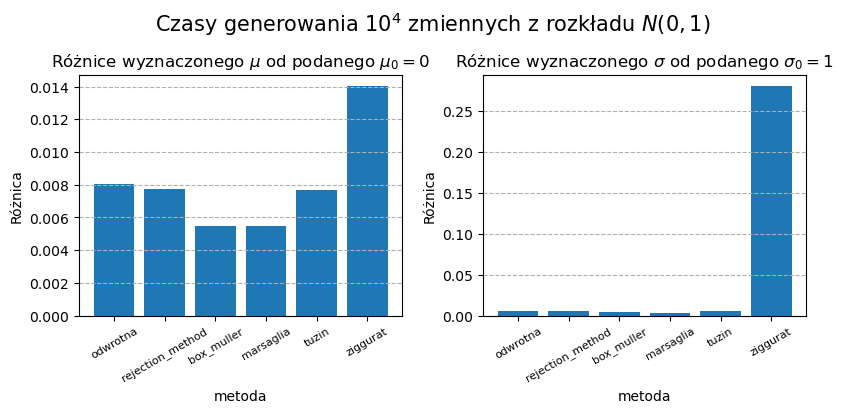

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.tight_layout()

axes[0].bar(range(6), list(d_mu.values()), align="center")
axes[0].set_xticks(range(6), list(d_mu.keys()), fontsize=8, rotation=30)
axes[0].grid(axis="y", linestyle="--")
axes[0].set_xlabel("metoda")
axes[0].set_ylabel("Różnica")
axes[0].set_title(r"Różnice wyznaczonego $\mu$ od podanego $\mu_0 = 0$")

axes[1].bar(range(6), list(d_s.values()), align="center")
axes[1].set_xticks(range(6), list(d_s.keys()), fontsize=8, rotation=30)
axes[1].grid(axis="y", linestyle="--")
axes[1].set_xlabel("metoda")
axes[1].set_ylabel("Różnica")
axes[1].set_title(r"Różnice wyznaczonego $\sigma$ od podanego $\sigma_0 = 1$")

fig.suptitle(
    "Czasy generowania $10^4$ zmiennych z rozkładu $N(0,1)$", fontsize=15, y=1.15
)

fig.subplots_adjust(wspace=0.25)

Metoda Box'a-Muller'a ma najmniejsza różnicę w wartościach $\mu$ spośród badanych metod. Pozostałe metody są na porównywalnym poziomie zarówno dla $\mu$ jak i $\sigma$ oprócz metody zigguratu, która w obu przypadkach znacząco odstaje od wartości dla pozostałych algorytmów. Potwierdza to wnioski wyciągnięte z wcześniejszego przedstawienia gęstości i dystrybuanty empirycznej próby wygenerowanej metodą zigguratu.

# Podsumowanie

Najefektywniejszą metodą, zarówno czasowo jak i pod względem zbliżenia rozkładu do $N(0,1)$, jest metoda Box'a-Muller'a. Najgorzej we wszystkich przeprowadzonych testach wypadł algorytm zigguratu. Pozostałe metody, tj. metoda odwrotnej dystrybuanty, akceptacji-odrzucenia, marsagli i tuzina, są porównywalnie dokładne, a ich czasy nie różnią się znacząco.